# Momentum, Volatility, and Volume Factors in U.S. Stock Returns

**ISYE 4031 Final Project**  
*Regression & Forecasting, Georgia Tech*

## Project Overview

This notebook analyzes the relationship between **momentum**, **volatility**, and **volume** factors in U.S. stock returns using S&P 500 data.

### Research Questions:
1. Do momentum indicators significantly predict future stock returns?
2. How does volatility clustering affect return predictability? 
3. Is trading volume a reliable indicator of price direction?

---

In [31]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
from bs4 import BeautifulSoup
import requests, re
import ta

---
### S&P 500 Stock List
We start by scraping the current S&P 500 stock list from a reliable financial data source.

**Data Source**: [Stock Analysis - S&P 500](https://stockanalysis.com/list/sp-500-stocks/)

**Key Information Collected**:
- Stock symbols (tickers)
- Market capitalization



In [32]:
url = 'https://stockanalysis.com/list/sp-500-stocks/'
resp = requests.get(url)
soup = BeautifulSoup(resp.text, 'html.parser')

# Find the table and extract headers
table = soup.find('table', class_='symbol-table svelte-1ro3niy')
headers = [th.get_text(strip=True) for th in table.find('tr').find_all('th')]

# Extract all row data
stocks_data = []
for row in table.find_all('tr')[1:]:  # Skip header row
    row_data = [cell.get_text(strip=True) for cell in row.find_all('td')]
    stocks_data.append(row_data)

# Create DataFrame and set No. column as index
sp500_df = pd.DataFrame(stocks_data, columns=headers)
sp500_df = sp500_df.set_index('No.')

print("\nFirst 10 rows:")
print(sp500_df.head(10)[['Symbol', 'Market Cap']])


First 10 rows:
    Symbol Market Cap
No.                  
1     NVDA      4.51T
2     AAPL      4.05T
3     MSFT      3.78T
4     GOOG      3.46T
5    GOOGL      3.37T
6     AMZN      2.56T
7     AVGO      1.58T
8     META      1.53T
9     TSLA      1.34T
10   BRK.B      1.09T


---

### Stock Selection & Date Range Setup

**Stock Selection Process:**
- Extract first 50 companies from S&P 500 list for analysis
- Focus on established companies for reliable historical data

**Analysis Time Period:**
- **Start Date**: January 1, 2021
- **End Date**: December 27, 2024
- **Duration**: 4 years of market data
- **Purpose**: Capture post-pandemic market trends and recovery patterns

> **Note**: Using a subset of the top 50 stocks for computational efficiency and financial significance.



In [33]:
# Change this to 50 later, just 3 now for computing efficiency
num_stocks_chosen = 5

# Adding one to properly reflect the number of stocks chosen when it's 10 or more because of stocks with dots in their tickers being filtered out
num_stocks = num_stocks_chosen + 1 if num_stocks_chosen >= 10 else num_stocks_chosen

# Get the list of stock tickers from the DataFrame
stocks = sp500_df.head(num_stocks)['Symbol'].tolist()

# Filter out all tickers that contain dots (they often cause yfinance issues)
stocks = [ticker for ticker in stocks if '.' not in ticker]

# Sort the list of stocks alphabetically
stocks.sort()


# Create start and end date variables for use later
startDate = dt.date(2021, 1, 1)
endDate = dt.date(2024, 12, 27)


# Print out list of stocks chosen and length of list
print(f"Selected stocks: {stocks}")
print(f"Total stocks: {len(stocks)}")

Selected stocks: ['AAPL', 'GOOG', 'GOOGL', 'MSFT', 'NVDA']
Total stocks: 5


---

### Weekly Returns and Factor Calculation

**Objective**: Calculate weekly log returns and prepare data structure for technical indicator analysis.

**Key Metrics**:
- **Weekly Log Returns**: `ln(Close/Open) × 100` for price movement analysis
- **ROC** Rate of Change indicator for momentum analysis.
- **RVOL** Relative Volume indicator for volume analysis.
- **BBW** Bollinger Band width indicator for volatility analysis.

**Data Structure**:
- Multi-level columns for organized factor storage
- Separate columns for each technical indicator per stock
- Week numbering for time series tracking

In [34]:
# Download daily data for extended period for more precise indicator calculations
download = yf.download(
    tickers = stocks,
    start = startDate,
    end = endDate,
    actions = False, threads = True, auto_adjust = True, rounding = True,
    group_by = 'tickers', 
    interval = '1wk'  # Daily data for daily-based indicators
)
display(download)

[*********************100%***********************]  5 of 5 completed


Ticker        GOOG                          ...    AAPL                           
Price         Open    High     Low   Close  ...    High     Low   Close     Volume
Date                                        ...                                   
2021-01-01   87.28   88.81   84.37   88.76  ...  130.06  123.02  127.44  505633000
2021-01-08   88.79   89.88   85.68   86.42  ...  129.11  123.49  125.49  476352400
2021-01-15   86.32   96.09   85.49   93.92  ...  135.96  123.57  133.24  426826200
2021-01-22   94.14   95.82   89.84   92.52  ...  141.24  131.44  133.45  653926600
2021-01-29   91.68  105.11   89.89  102.42  ...  133.75  126.75  133.74  541133000
...            ...     ...     ...     ...  ...     ...     ...     ...        ...
2024-11-22  166.43  170.75  164.99  170.08  ...  234.63  227.03  233.87  207805700
2024-11-29  169.32  176.94  168.01  173.55  ...  243.44  232.92  241.95  199897300
2024-12-06  173.12  196.03  172.79  192.79  ...  249.67  240.66  246.84  196417900
2024-12-13  192.09  202.23  188.67  189.09  ...  253.14  245.13  248.67  253862900
2024-12-20  186.41  197.52  185.77  196.46  ...  258.93  244.58  257.85  238825900

[208 rows x 25 columns]

**Download and extract relevant data on a weekly basis**

In [36]:
# Download weekly data
download = yf.download(
    tickers = stocks,
    start = startDate,
    end = endDate,
    actions = False, threads = True, auto_adjust = True, rounding = True,
    group_by = 'tickers', 
    interval = '1d'
)

# Extract OHLCV data
open_data = download.xs('Open', level=1, axis=1)
close_data = download.xs('Close', level=1, axis=1)
high_data = download.xs('High', level=1, axis=1)
low_data = download.xs('Low', level=1, axis=1)
volume_data = download.xs('Volume', level=1, axis=1)

# Convert daily to weekly data (Friday close) for analysis
weekly_open = download.xs('Open', level=1, axis=1).resample('W-FRI').first()
weekly_close = close_data.resample('W-FRI').last()
weekly_high = high_data.resample('W-FRI').max()
weekly_low = low_data.resample('W-FRI').min()
weekly_volume = volume_data.resample('W-FRI').sum()

**Calculate and store key indicators**

In [37]:
# Calculate weekly log returns
log_returns = (np.log(weekly_close / weekly_open) * 100)

# Create MultiIndex DataFrame
columns = []
for ticker in stocks:
    # extend to include log return, ROC, RVOL, BBW for each ticker
    columns.extend([(ticker, 'Log_Return_%'), (ticker, 'ROC'), (ticker, 'RVOL'), (ticker, 'BBW')])
# Make sub-columns accessible
multi_columns = pd.MultiIndex.from_tuples(columns, names=['Ticker', 'Metric'])
# Construct df with weekly data indexed with the analysis period's close date and columns that we just defined
weekly_data = pd.DataFrame(index=weekly_open.index, columns=multi_columns)


# Create function to lag indicators by one week. Idea is that indicators of last week might be able to tell us stuff
def lag_indicator(weekly_full):
    lagged_values = []
    for current_week in weekly_close.index:
        prev_week_candidates = weekly_full.index[weekly_full.index < current_week]
        if len(prev_week_candidates) > 0:
            prev_week = prev_week_candidates[-1]
            lagged_values.append(weekly_full.loc[prev_week])
        else:
            lagged_values.append(np.nan)

# Calculate indicators for each stock using TA library
for ticker in stocks:
    if ticker in close_data.columns:

        # Get full daily time series for calculations (including lookback period)
        ticker_daily_close = close_data[ticker].dropna()
        ticker_daily_volume = volume_data[ticker].dropna()
        
        if len(ticker_daily_close) > 60:  # Need sufficient daily data for indicators
            
            # 1. Log Returns (current week - already calculated from weekly data)
            weekly_data[(ticker, 'Log_Return_%')] = log_returns[ticker].round(2)
            
            
            # 2. Rate of Change (ROC) - 36-day using TA library, lagged by 1 week
            
            # Calculate daily ROC using TA library (momentum indicators)
            roc_36d = ta.momentum.ROCIndicator(close=ticker_daily_close, window=36).roc()
            # Convert to weekly (take Friday values) using the FULL dataset including lookback
            roc_weekly_full = roc_36d.resample('W-FRI').last()

            roc_lagged_values = lag_indicator(roc_weekly_full)
            
            weekly_data[(ticker, 'ROC')] = pd.Series(roc_lagged_values, index=weekly_close.index).round(2)
        

            # 3. Relative Volume (RVOL) - Current volume vs 50-day SMA using TA library, lagged by 1 week

            # Calculate volume SMA using TA library
            volume_sma_50d = ta.trend.SMAIndicator(close=ticker_daily_volume, window=50).sma_indicator()
            rvol_daily = ticker_daily_volume / volume_sma_50d
            # Convert to weekly using the FULL dataset including lookback
            rvol_weekly_full = rvol_daily.resample('W-FRI').last()
            
            rvol_lagged_values = lag_indicator(rvol_weekly_full)

            weekly_data[(ticker, 'RVOL')] = pd.Series(rvol_lagged_values, index=weekly_close.index).round(2)
            


            # 4. Bollinger Band Width (BBW) - using TA library, lagged by 1 week

            # Calculate Bollinger Bands using TA library (36-day window, 2 std dev)
            bb_indicator = ta.volatility.BollingerBands(
                close=ticker_daily_close, 
                window=36, 
                window_dev=2
            )
            bb_upper = bb_indicator.bollinger_hband()
            bb_lower = bb_indicator.bollinger_lband()
            bb_mavg = bb_indicator.bollinger_mavg()
            
            # Calculate BBW as percentage width
            bbw_daily = ((bb_upper - bb_lower) / bb_mavg) * 100
            # Convert to weekly using the FULL dataset including lookback
            bbw_weekly_full = bbw_daily.resample('W-FRI').last()

            bbw_lagged_values = lag_indicator(bbw_weekly_full)

            weekly_data[(ticker, 'BBW')] = pd.Series(bbw_lagged_values, index=weekly_close.index).round(2)
        
        else:
            # Fill with NaN if insufficient data
            weekly_data[(ticker, 'Log_Return_%')] = np.nan
            weekly_data[(ticker, 'ROC')] = np.nan
            weekly_data[(ticker, 'RVOL')] = np.nan
            weekly_data[(ticker, 'BBW')] = np.nan

# Add week numbers as a separate column
weekly_data.insert(0, 'Week', range(1, len(weekly_data) + 1))

print(f"Technical Analysis with TA Library Complete!")
print(f"Total weeks: {len(weekly_data)}")
print(f"Date range: {weekly_data.index[0].date()} to {weekly_data.index[-1].date()}")
print(f"DataFrame shape: {weekly_data.shape}")
print(f"Stocks analyzed: {len(stocks)}")
print(f"\nCalculated Indicators Using TA Library (All Lagged by 1 Week):")
print("• Log_Return_%: Weekly log returns (current week)")
print("• ROC: 36-day Rate of Change using ta.momentum.ROCIndicator (lagged 1 week)")
print("• RVOL: Relative Volume vs 50-day SMA using ta.trend.SMAIndicator (lagged 1 week)")
print("• BBW: Bollinger Band Width using ta.volatility.BollingerBands (lagged 1 week)")

print(f"\nUpdated Regression Format:")
print("Return_{i,t} = β_MOM×ROC_36d_{i,t-1} + β_BBW×BBW_36d_{i,t-1} + β_VOL×RVOL_50d_{i,t-1} + ε_{i,t}")

display(weekly_data)


Technical Analysis with TA Library Complete!
Total weeks: 208
Date range: 2021-01-08 to 2024-12-27
DataFrame shape: (208, 21)
Stocks analyzed: 5

Calculated Indicators Using TA Library (All Lagged by 1 Week):
• Log_Return_%: Weekly log returns (current week)
• ROC: 36-day Rate of Change using ta.momentum.ROCIndicator (lagged 1 week)
• RVOL: Relative Volume vs 50-day SMA using ta.trend.SMAIndicator (lagged 1 week)
• BBW: Bollinger Band Width using ta.volatility.BollingerBands (lagged 1 week)

Updated Regression Format:
Return_{i,t} = β_MOM×ROC_36d_{i,t-1} + β_BBW×BBW_36d_{i,t-1} + β_VOL×RVOL_50d_{i,t-1} + ε_{i,t}


Ticker     Week         AAPL               ... MSFT         NVDA             
Metric          Log_Return_% ROC RVOL BBW  ...  BBW Log_Return_% ROC RVOL BBW
Date                                       ...                               
2021-01-08    1        -1.11 NaN  NaN NaN  ...  NaN         1.29 NaN  NaN NaN
2021-01-15    2        -1.60 NaN  NaN NaN  ...  NaN        -4.28 NaN  NaN NaN
2021-01-22    3         8.47 NaN  NaN NaN  ...  NaN         5.18 NaN  NaN NaN
2021-01-29    4        -8.08 NaN  NaN NaN  ...  NaN        -5.92 NaN  NaN NaN
2021-02-05    5         2.38 NaN  NaN NaN  ...  NaN         3.99 NaN  NaN NaN
...         ...          ...  ..  ...  ..  ...  ...          ...  ..  ...  ..
2024-11-29  204         2.50 NaN  NaN NaN  ...  NaN        -2.67 NaN  NaN NaN
2024-12-06  205         2.32 NaN  NaN NaN  ...  NaN         2.57 NaN  NaN NaN
2024-12-13  206         2.57 NaN  NaN NaN  ...  NaN        -3.46 NaN  NaN NaN
2024-12-20  207         2.59 NaN  NaN NaN  ...  NaN         0.39 NaN  NaN NaN
2024-12-27  208         1.65 NaN  NaN NaN  ...  NaN         2.64 NaN  NaN NaN

[208 rows x 21 columns]

Function creating dataframe with each week's metrics

In [38]:
# Get unique ticker names from the MultiIndex columns. First one is 'Week' so skip it
stock_tickers = weekly_data.columns.get_level_values('Ticker').unique().tolist()
stock_tickers = [ticker for ticker in stock_tickers if ticker != 'Week']
print(f"Stock tickers: {stock_tickers}")

# Create dataframe for week data where row is stock ticker and columns are metrics
def get_week_x_data(tickers, week_number):
    week_data = pd.DataFrame(index=tickers, columns=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    
    index = week_number - 1  # Convert to zero-based index
    
    for ticker in tickers:
        # Access each metric individually from the MultiIndex DataFrame
        week_data.loc[ticker, 'Log_Return_%'] = weekly_data[(ticker, 'Log_Return_%')].iloc[index]
        week_data.loc[ticker, 'ROC'] = weekly_data[(ticker, 'ROC')].iloc[index]
        week_data.loc[ticker, 'RVOL'] = weekly_data[(ticker, 'RVOL')].iloc[index]
        week_data.loc[ticker, 'BBW'] = weekly_data[(ticker, 'BBW')].iloc[index]
    
    # Drop row if NaN found in any column
    week_data_clean = week_data.dropna(subset=['Log_Return_%', 'ROC', 'RVOL', 'BBW'])
    return week_data_clean

# Output
week_num = 1
week_result = get_week_x_data(stock_tickers, week_num)
print(f"\nWeek {week_num} data:")
display(week_result)

Stock tickers: ['AAPL', 'GOOG', 'GOOGL', 'MSFT', 'NVDA']

Week 1 data:


,Log_Return_%,ROC,RVOL,BBW


**Get Regression Coefficients**

In [39]:
import statsmodels.api as sm

y = week_result['Log_Return_%'].values.astype(float)
X = week_result[['ROC', 'RVOL', 'BBW']].values.astype(float)
model = sm.OLS(y,X).fit()
print(model.summary())

ValueError: zero-size array to reduction operation maximum which has no identity

Create scatterplot of Rate of Change vs Log Return for a given week

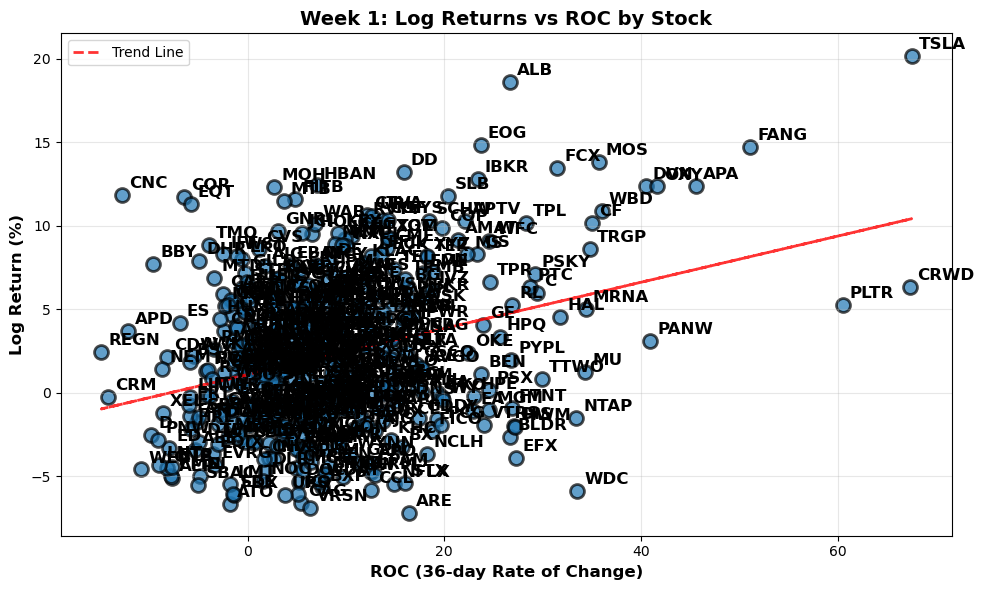

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract week 1 data
week_1_data = weekly_data.iloc[0]  # First row (week 1)

# Prepare data for scatter plot
plot_data = []
for ticker in stocks:
    log_return = week_1_data[(ticker, 'Log_Return_%')]
    roc = week_1_data[(ticker, 'ROC')]
    
    # Only include if both values are not NaN
    if pd.notna(log_return) and pd.notna(roc):
        plot_data.append({
            'Ticker': ticker,
            'Log_Return_%': log_return,
            'ROC': roc
        })

# Convert to DataFrame
plot_df = pd.DataFrame(plot_data)

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(plot_df['ROC'], plot_df['Log_Return_%'], 
           s=100, alpha=0.7, edgecolors='black', linewidth=2)

# Add labels for each point
for i, row in plot_df.iterrows():
    plt.annotate(row['Ticker'], 
                (row['ROC'], row['Log_Return_%']),
                xytext=(5, 5), textcoords='offset points',
                fontsize=12, fontweight='bold')

plt.xlabel('ROC (36-day Rate of Change)', fontsize=12, fontweight='bold')
plt.ylabel('Log Return (%)', fontsize=12, fontweight='bold')
plt.title('Week 1: Log Returns vs ROC by Stock', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)

# Add a trend line if we have data
if len(plot_df) > 1:
    z = np.polyfit(plot_df['ROC'], plot_df['Log_Return_%'], 1)
    p = np.poly1d(z)
    plt.plot(plot_df['ROC'], p(plot_df['ROC']), 
             "r--", alpha=0.8, linewidth=2, label=f'Trend Line')
    plt.legend()

plt.tight_layout()
plt.show()

/var/folders/6y/spt598r17_dgcfx4prrmwk4m0000gq/T/ipykernel_47854/3735538439.py:9: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  week_result_clean = week_result.replace([np.inf, -np.inf], np.nan).infer_objects(copy=False).dropna()
/Users/pedro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/pedro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_

Original data shape: (485, 4)
Cleaned data shape: (485, 4)


/Users/pedro/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


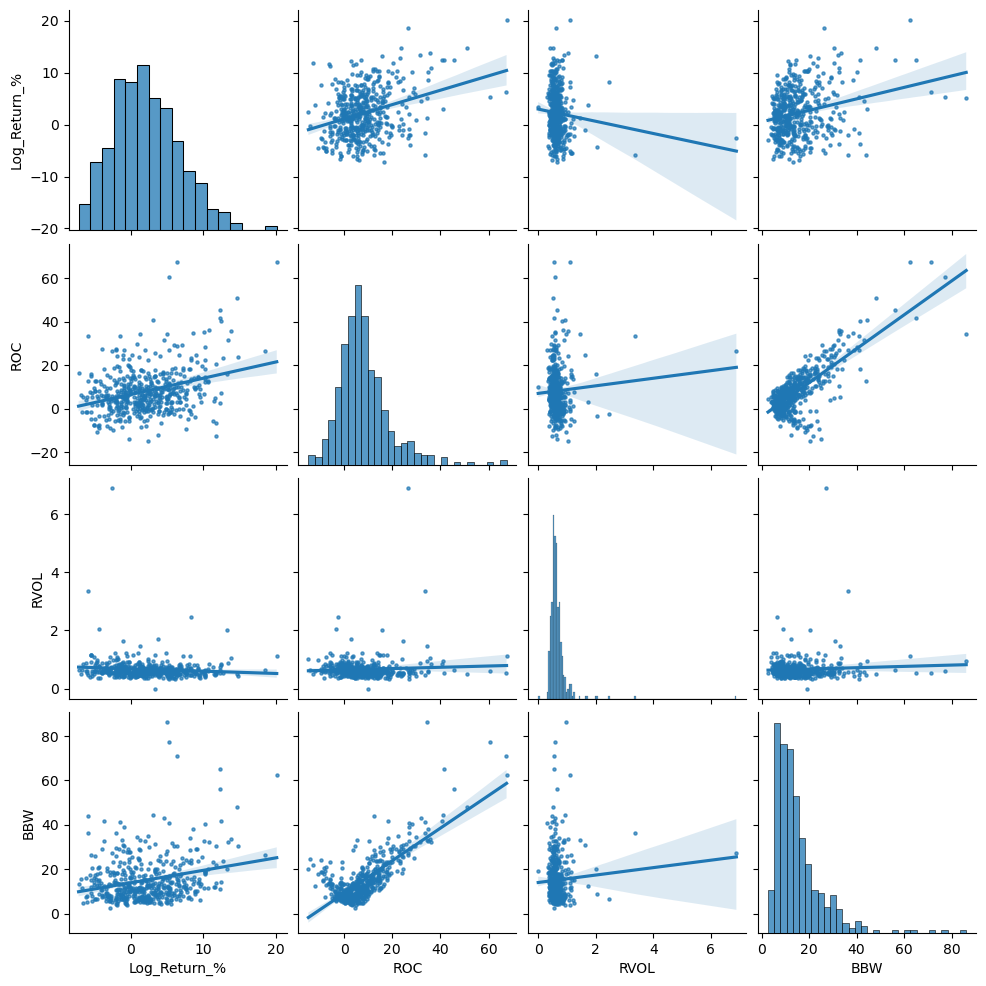

In [ ]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# display(week_result)

# Clean the data by replacing inf and -inf values with NaN, then drop NaN rows
week_result_clean = week_result.replace([np.inf, -np.inf], np.nan).infer_objects(copy=False).dropna()

print(f"Original data shape: {week_result.shape}")
print(f"Cleaned data shape: {week_result_clean.shape}")

# Create pairplot for the cleaned week result with trend lines in each scatter plot
# sns.pairplot(week_result_clean, kind='scatter', plot_kws={'alpha': 1})
sns.pairplot(week_result_clean, kind='reg', plot_kws={'scatter_kws': {'alpha': 0.7, 's': 5}}, 
             diag_kind='hist')
plt.show()